# Introduction

The following uses sklearn's SVC (suport vector classifier) to fit a classifier that distinguishes between a pair of sketch categories from the Quick, Draw! dataset from Google:

https://console.cloud.google.com/storage/browser/quickdraw_dataset/full/numpy_bitmap/?pli=1

Categories were chosen below to make a somewhat difficult comparison (two objects that typically look alike)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import copy
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

from sklearn.model_selection import train_test_split, GridSearchCV, KFold, StratifiedKFold, cross_validate
from sklearn.svm import SVC

from utilities import computeLearningCurve, plotScoreCurve, plotTimeCurve, plotIterationCurve, plotConfusionMatrix, getDrawData, drawIncorrectSketches, heatmap

# Settings

In [3]:
# Random seed used for all "random" generators
randomSeed = 1

# Number of parallel jobs used for some sklearn routines (-1 means use all cpus)
njobs = -1

# Fractional size of test dataset
testSize = 1/5.

# Number of folds for GridSearchCV
nfolds = 5

# Settings to control which features are used
pRows = 28
pCols = 28
pColNames = list(range(pRows * pCols))
pScale = 255.0 # Scale factor for pixels.  Pixel raw data is 0 to 255.  Set to 1 to avoid scaling

# Number of samples PER CATEGORY (defined below)
nSamples = 7500

# Names of all models to include
# names = ['baseball', 'basketball', 'camel', 'cow', 'clock', 'wristwatch']
names = ['baseball', 'basketball']

# Plot min/max extents for all accuracy plots
accuracyMin = 0.6
accuracyMax = 1.0

# Folds (denoted by number of data points used) for learning curve
learningCurveFolds = np.concatenate([np.geomspace(10, 1000, 5).round(), np.array([2000, 4000, 6000, 9000])]).astype('int')

In [4]:
# Used for plot names
est = "quickdraw_svc"
scoreText = "Score (Classification Accuracy)"

# Load Data

In [5]:
dataDict = getDrawData(names, nSamples=nSamples)
data = dataDict['df']
nameDict = dataDict['nameDict']

print("")
print("Loaded the following named categories, with classNumbers shown")
print(nameDict)

# Scale pixel data
for col in pColNames:
    data[col] = data[col] / pScale

Loading 7500 samples for baseball from ./data/full_numpy_bitmap_baseball.npy
Loading 7500 samples for basketball from ./data/full_numpy_bitmap_basketball.npy

Loaded the following named categories, with classNumbers shown
{'baseball': 0, 'basketball': 1}


In [6]:
# Create X, y, XTest, yTest using just the features we care about...

XFull = data.loc[:, pColNames].values
print(f'XFull.shape = {XFull.shape}')
yFull = data.loc[:, 'classNumber'].values
print(f'yFull.shape = {yFull.shape}')

X, XTest, y, yTest = train_test_split(XFull, yFull, test_size=testSize, 
                                      random_state=randomSeed, stratify=yFull)

print('')
print(f'X.shape = {X.shape}')
print(f'y.shape = {y.shape}')
print(f'Ratio of y=1 to y=0 for Training data: {(y == 1).sum() / float(len(y))} (should be 0.5)')

print('')
print(f'XTest.shape = {XTest.shape}')
print(f'yTest.shape = {yTest.shape}')
print(f'Ratio of yTest=1 to yTest=0 for Test data: {(yTest == 1).sum() / float(len(yTest))} (should be 0.5)')

XFull.shape = (15000, 784)
yFull.shape = (15000,)

X.shape = (12000, 784)
y.shape = (12000,)
Ratio of y=1 to y=0 for Training data: 0.5 (should be 0.5)

XTest.shape = (3000, 784)
yTest.shape = (3000,)
Ratio of yTest=1 to yTest=0 for Test data: 0.5 (should be 0.5)


# Initial Parameter Setting using GridSearchCV with Nominal Data Set

Examine the hyperparameter space using GridSearchCV.

First examine using a linear kernel

In [7]:
Cs_rbf = np.geomspace(0.1, 1000, 5)
gammas_rbf = np.geomspace(0.00001, 1.0, 6)

Cs_linear = np.geomspace(0.001, 10, 5)

paramGrid = [
    {
        'kernel': ['linear'],
        'C': Cs_linear,
    },
    {
        'kernel': ['rbf'],
        'C':Cs_rbf,
        'gamma': gammas_rbf,
    },
]


nData = 2000
XSubset = X[:nData]
ySubset = y[:nData]

gs = GridSearchCV(SVC(), param_grid=paramGrid, cv=nfolds, n_jobs=njobs, 
                      verbose=10, return_train_score=True)

In [8]:
# fit!
print(f"Fitting model using {XSubset.shape[0]} data samples")
gs.fit(XSubset, ySubset)

pltNameSuffix = '_' + '_initial'
with open(est + pltNameSuffix + "_gs.pkl", 'wb') as fout:
    pickle.dump(gs, file=fout)

Fitting model using 2000 data samples
Fitting 5 folds for each of 35 candidates, totalling 175 fits


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   17.5s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   24.3s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   40.2s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   54.1s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 175 out of 175 | elapsed:  3.9min finished


In [9]:
gs_results_df = pd.DataFrame(gs.cv_results_)
gs_results_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_kernel,param_gamma,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,2.419331,0.322464,0.589822,0.046794,0.001,linear,NaN,"{'C': 0.001, 'kernel': 'linear'}",0.852868,0.8625,...,0.8360,0.026092,4,0.846779,0.843750,0.848125,0.854375,0.861337,0.850873,0.006274
1,2.734092,0.364230,0.574462,0.082629,0.01,linear,NaN,"{'C': 0.01, 'kernel': 'linear'}",0.832918,0.8375,...,0.8300,0.016780,6,0.876173,0.871250,0.873125,0.873750,0.878201,0.874500,0.002429
2,3.196055,0.122625,0.558308,0.025115,0.1,linear,NaN,"{'C': 0.1, 'kernel': 'linear'}",0.795511,0.7700,...,0.7925,0.016666,16,0.909318,0.903750,0.906875,0.900000,0.908807,0.905750,0.003476
3,5.103355,0.365831,0.434639,0.020414,1,linear,NaN,"{'C': 1.0, 'kernel': 'linear'}",0.743142,0.7400,...,0.7555,0.018588,21,0.943089,0.943125,0.936875,0.934375,0.947533,0.940999,0.004743
4,17.318925,3.222811,0.411301,0.022870,10,linear,NaN,"{'C': 10.0, 'kernel': 'linear'}",0.718204,0.6750,...,0.7155,0.022025,22,0.987492,0.978125,0.973125,0.976875,0.985634,0.980250,0.005443
5,4.680287,0.098152,1.170670,0.052959,0.1,rbf,1e-05,"{'C': 0.1, 'gamma': 1e-05, 'kernel': 'rbf'}",0.511222,0.5100,...,0.5105,0.000613,27,0.510319,0.510625,0.510625,0.510625,0.510306,0.510500,0.000153
6,5.051694,0.424900,1.227518,0.106587,0.1,rbf,0.0001,"{'C': 0.1, 'gamma': 0.0001, 'kernel': 'rbf'}",0.511222,0.5100,...,0.5105,0.000613,27,0.510319,0.510625,0.510625,0.510625,0.510306,0.510500,0.000153
7,5.545175,0.023626,1.287957,0.008594,0.1,rbf,0.001,"{'C': 0.1, 'gamma': 0.001, 'kernel': 'rbf'}",0.822943,0.8175,...,0.7910,0.025635,17,0.791745,0.791875,0.801875,0.801875,0.812617,0.799997,0.007751
8,4.846843,0.031860,1.122398,0.037586,0.1,rbf,0.01,"{'C': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}",0.845387,0.8575,...,0.8245,0.026987,7,0.851157,0.849375,0.855625,0.855625,0.860712,0.854499,0.003964
9,5.824627,0.097724,1.343209,0.037942,0.1,rbf,0.1,"{'C': 0.1, 'gamma': 0.1, 'kernel': 'rbf'}",0.511222,0.5100,...,0.5105,0.000613,27,0.510319,0.510625,0.510625,0.510625,0.510306,0.510500,0.000153


Plots for linear kernel (only one hyperparameter)

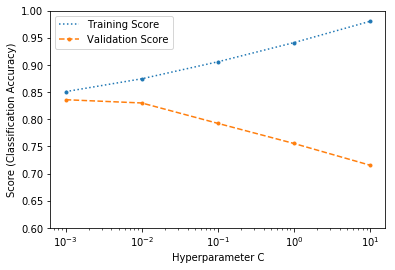

In [10]:
fig, ax = plt.subplots()

gs_results_df.loc[gs_results_df.param_kernel == 'linear'].plot(x='param_C', y='mean_train_score', label='Training Score', ax=ax, marker='.', ls=":", logx=True)
gs_results_df.loc[gs_results_df.param_kernel == 'linear'].plot(x='param_C', y='mean_test_score', label='Validation Score', ax=ax, marker='.', ls="--", logx=True)
gs_results_df.to_csv(est + pltNameSuffix + "gs_results.csv")

ax.set_xlabel("Hyperparameter C")
ax.set_ylabel(scoreText)
ax.set_ylim(bottom=accuracyMin, top=accuracyMax)

fig.savefig(est + pltNameSuffix + "_linear_gs")

Plots for rbf kernel (two hyperparameters)

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1e9da810400>)

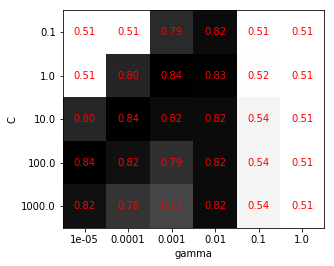

In [11]:
tempdf = gs_results_df.loc[gs_results_df.param_kernel == "rbf"]
toPlot = np.zeros((len(Cs_rbf), len(gammas_rbf)))
for i, hls in enumerate(Cs_rbf):
    for j, a in enumerate(gammas_rbf):
        k = i * len(gammas_rbf) + j
        toPlot[i, j] = tempdf.iloc[k].mean_test_score
heatmap(toPlot, gammas_rbf, Cs_rbf, xlabel="gamma", ylabel="C", savefig=est + pltNameSuffix + "_rbf_gs")

In [12]:
print(f'From this, we choose the following parameters for computing the learning curve:\n{gs.best_params_}')
score = gs.score(XTest, yTest)
print(f'This model has score of {gs.best_score_} in cross validation for grid search and {score} on the held-out test data')

From this, we choose the following parameters for computing the learning curve:
{'C': 100.0, 'gamma': 1e-05, 'kernel': 'rbf'}
This model has score of 0.8375 in cross validation for grid search and 0.819 on the held-out test data


# Learning Curves

Produce learning curves (train/test accuracy vs number of examples and train/score time vs number of examples) using the above chosen parameters to determine:

* Whether the classifier is bias or variance limited
* Limit to which more data points will not be helpful

This is repeated for both linear and rbf kernels

In [14]:
lc_params = {'C': 0.001, 'kernel': 'linear'}

# Training time for SVC's linear kernel gets very long with large data (because it retains more support vectors than rbf?)
# localFolds = [10, 32, 100, 316, 1000, 2000]

lcNameBase = est + "_" + lc_params['kernel'] + "_" + "_lc_" + str(len(learningCurveFolds)) + "f_" + str(X.shape[0]) + "ex"
lcName = lcNameBase  + ".pkl"

print(f"Computing learning curves with params: \n{lc_params}")
print(f"Over {len(learningCurveFolds)} folds: {learningCurveFolds}")
# Note that computeLearningCurve with testSize specified splits X, y into a test and validation set 
# before training (validation set is used for validation curve)
lc = computeLearningCurve(SVC(**lc_params), X, y, testSize = testSize,
                          learningCurveFolds=learningCurveFolds, stratifyLearningCurveFolds=True, 
                         randomSeed=randomSeed, saveas=lcName, returnEstimators=True)

Computing learning curves with params: 
{'C': 0.001, 'kernel': 'linear'}
Over 9 folds: [  10   32  100  316 1000 2000 4000 6000 9000]
Indices included at fold 0: 10
	Model trained in 0.00s
	Model Scored on Training Data in 0.00s
	Model Scored on Test Data in 0.02s
	Total time for this iteration = 0.02s
Indices included at fold 1: 32
	Model trained in 0.00s
	Model Scored on Training Data in 0.00s
	Model Scored on Test Data in 0.07s
	Total time for this iteration = 0.07s
Indices included at fold 2: 100
	Model trained in 0.01s
	Model Scored on Training Data in 0.01s
	Model Scored on Test Data in 0.20s
	Total time for this iteration = 0.21s
Indices included at fold 3: 316
	Model trained in 0.08s
	Model Scored on Training Data in 0.08s
	Model Scored on Test Data in 0.59s
	Total time for this iteration = 0.75s
Indices included at fold 4: 1000
	Model trained in 0.70s
	Model Scored on Training Data in 0.66s
	Model Scored on Test Data in 1.62s
	Total time for this iteration = 2.98s
Indices incl

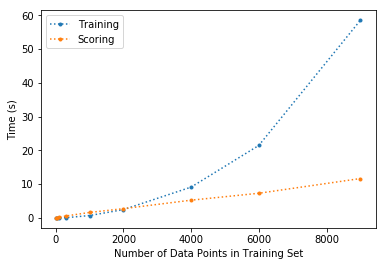

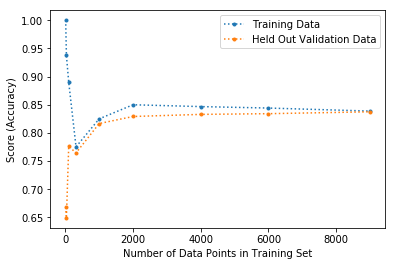

In [15]:
plotTimeCurve(lc, savefig = lcNameBase + "_time")
# plt.legend()
plt.show()

plotScoreCurve(lc, savefig = lcNameBase + "_score")
# plt.legend()
plt.show()

In [16]:
iBest = np.argmax(lc['test_score'])
bestScore = lc['test_score'][iBest]
bestData = lc['n_data'][iBest]
print(f'Best validation score with linear kernel of {bestScore:.3} achieved with {bestData:d} samples')

Best validation score with linear kernel of 0.838 achieved with 9000 samples


In [18]:
lc_params = copy.deepcopy(gs.best_params_)

lc_params['kernel'] = 'rbf'

lcNameBase = est + "_" + lc_params['kernel'] + "_" + "_lc_" + str(len(learningCurveFolds)) + "f_" + str(X.shape[0]) + "ex"

lcName = lcNameBase  + ".pkl"

print(f"Computing learning curves with params: \n{lc_params}")
print(f"Over {len(learningCurveFolds)} folds: {learningCurveFolds}")
# Note that computeLearningCurve with testSize specified splits X, y into a test and validation set 
# before training (validation set is used for validation curve)
lc = computeLearningCurve(SVC(**lc_params), X, y, testSize = testSize,
                          learningCurveFolds=learningCurveFolds, stratifyLearningCurveFolds=True, 
                         randomSeed=randomSeed, saveas=lcName, returnEstimators=True)

Computing learning curves with params: 
{'C': 100.0, 'gamma': 1e-05, 'kernel': 'rbf'}
Over 9 folds: [  10   32  100  316 1000 2000 4000 6000 9000]
Indices included at fold 0: 10
	Model trained in 0.00s
	Model Scored on Training Data in 0.00s
	Model Scored on Test Data in 0.02s
	Total time for this iteration = 0.02s
Indices included at fold 1: 32
	Model trained in 0.00s
	Model Scored on Training Data in 0.00s
	Model Scored on Test Data in 0.07s
	Total time for this iteration = 0.07s
Indices included at fold 2: 100
	Model trained in 0.01s
	Model Scored on Training Data in 0.01s
	Model Scored on Test Data in 0.21s
	Total time for this iteration = 0.22s
Indices included at fold 3: 316
	Model trained in 0.08s
	Model Scored on Training Data in 0.07s
	Model Scored on Test Data in 0.56s
	Total time for this iteration = 0.72s
Indices included at fold 4: 1000
	Model trained in 0.67s
	Model Scored on Training Data in 0.62s
	Model Scored on Test Data in 1.46s
	Total time for this iteration = 2.75s

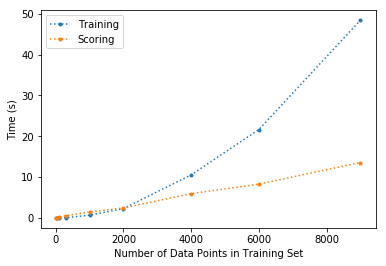

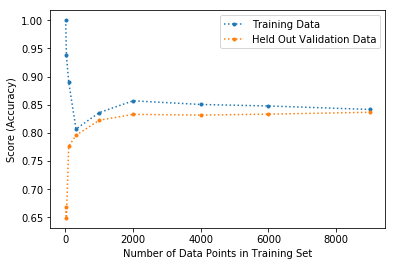

In [19]:
plotTimeCurve(lc, savefig = lcNameBase + "_time")
# plt.legend()
plt.show()

plotScoreCurve(lc, savefig = lcNameBase + "_score")
# plt.legend()
plt.show()

In [20]:
iBest = np.argmax(lc['test_score'])
bestScore = lc['test_score'][iBest]
bestData = lc['n_data'][iBest]
print(f'Best validation score of {bestScore:.3} achieved with {bestData:d} samples')

Best validation score of 0.837 achieved with 9000 samples


This shows that for the rbf kernel and these hyper parameters, the model barely improves with additional data.  And, given that the training and validation scores are nearly identical, the model appears to not be overfit.

In practice, the tradeoff between improved accuracy and prediction time would dictate what the "best" solution is here.  Below refits the model assuming the best solution prioritizes accuracy above training/predicting time. 

# Refit Model on Best Data

Assuming accuracy is most important, refit the model using a second GridSearchCV search for hyperparameters, then score the model on the held out test data. 

In [21]:
Cs_rbf = np.geomspace(10, 1000, 3)
gammas_rbf = np.geomspace(0.00001, 0.01, 4)

Cs_linear = np.geomspace(0.001, .1, 3)

paramGrid = [
    {
        'kernel': ['linear'],
        'C': Cs_linear,
    },
    {
        'kernel': ['rbf'],
        'C':Cs_rbf,
        'gamma': gammas_rbf,
    },
]


nData = bestData
XSubset = X[:nData]
ySubset = y[:nData]

gs = GridSearchCV(SVC(), param_grid=paramGrid, cv=nfolds, n_jobs=njobs, 
                      verbose=10, return_train_score=True)

In [22]:
# fit!
print(f"Fitting model using {XSubset.shape[0]} data samples")
gs.fit(XSubset, ySubset)
pltNameSuffix = '_final'
with open(est + pltNameSuffix + "_gs.pkl", 'wb') as fout:
    pickle.dump(gs, file=fout)

Fitting model using 9000 data samples
Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 11.5min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 14.9min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed: 18.2min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 22.9min
[Parallel(n_jobs=-1)]: Done  68 out of  75 | elapsed: 28.7min remaining:  2.9min
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed: 31.0min finished


In [23]:
gs_results_df = pd.DataFrame(gs.cv_results_)
gs_results_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_kernel,param_gamma,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,82.543318,1.112660,18.188771,0.455545,0.001,linear,NaN,"{'C': 0.001, 'kernel': 'linear'}",0.847307,0.824542,...,0.831889,0.009358,9,0.834977,0.838589,0.839583,0.835023,0.840161,0.837667,0.002235
1,74.627480,1.456928,15.231279,0.395808,0.01,linear,NaN,"{'C': 0.01, 'kernel': 'linear'}",0.845641,0.826208,...,0.834889,0.007596,3,0.844284,0.853313,0.850694,0.845716,0.851548,0.849111,0.003491
2,90.138013,1.358803,15.007277,0.119951,0.1,linear,NaN,"{'C': 0.1, 'kernel': 'linear'}",0.838423,0.817324,...,0.822889,0.008503,13,0.851368,0.856786,0.858333,0.853909,0.854465,0.854972,0.002407
3,110.687706,1.967044,27.186750,1.243669,10,rbf,1e-05,"{'C': 10.0, 'gamma': 1e-05, 'kernel': 'rbf'}",0.839534,0.815658,...,0.821444,0.010124,14,0.821503,0.825670,0.825833,0.821830,0.826830,0.824333,0.002216
4,82.186990,3.202872,17.993343,0.931675,10,rbf,0.0001,"{'C': 10.0, 'gamma': 0.0001, 'kernel': 'rbf'}",0.848418,0.828429,...,0.834667,0.008390,4,0.838172,0.845256,0.846806,0.838495,0.844605,0.842667,0.003611
5,82.798540,1.271806,16.625105,1.094455,10,rbf,0.001,"{'C': 10.0, 'gamma': 0.001, 'kernel': 'rbf'}",0.846752,0.825097,...,0.836444,0.008018,1,0.865398,0.873455,0.871389,0.865991,0.872101,0.869667,0.003316
6,142.656611,13.747894,23.400000,1.165091,10,rbf,0.01,"{'C': 10.0, 'gamma': 0.01, 'kernel': 'rbf'}",0.844531,0.827318,...,0.835222,0.014667,2,0.999722,0.999861,0.999861,0.999861,1.000000,0.999861,0.000088
7,81.921748,2.235246,16.545765,0.225763,100,rbf,1e-05,"{'C': 100.0, 'gamma': 1e-05, 'kernel': 'rbf'}",0.848418,0.828984,...,0.834444,0.008248,5,0.837755,0.844978,0.846250,0.838495,0.844605,0.842417,0.003554
8,73.441300,1.189617,15.214556,0.589906,100,rbf,0.0001,"{'C': 100.0, 'gamma': 0.0001, 'kernel': 'rbf'}",0.841199,0.825097,...,0.832778,0.006653,8,0.849701,0.856647,0.856250,0.851271,0.855853,0.853944,0.002878
9,101.731682,1.232782,16.888648,0.798542,100,rbf,0.001,"{'C': 100.0, 'gamma': 0.001, 'kernel': 'rbf'}",0.841755,0.818989,...,0.825667,0.011984,12,0.952632,0.953188,0.956944,0.953479,0.955145,0.954278,0.001575


Plots for linear kernel (only one hyperparameter)

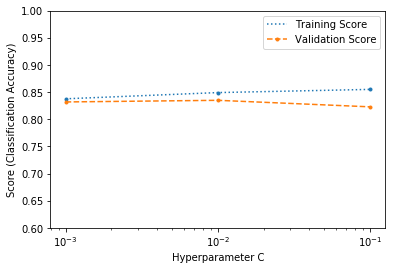

In [24]:
fig, ax = plt.subplots()

gs_results_df.loc[gs_results_df.param_kernel == 'linear'].plot(x='param_C', y='mean_train_score', label='Training Score', ax=ax, marker='.', ls=":", logx=True)
gs_results_df.loc[gs_results_df.param_kernel == 'linear'].plot(x='param_C', y='mean_test_score', label='Validation Score', ax=ax, marker='.', ls="--", logx=True)
gs_results_df.to_csv(est + pltNameSuffix + "gs_results.csv")

ax.set_xlabel("Hyperparameter C")
ax.set_ylabel(scoreText)
ax.set_ylim(bottom=accuracyMin, top=accuracyMax)

fig.savefig(est + pltNameSuffix + "_linear_gs")

Plots for rbf kernel (two hyperparameters)

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1e985fc99b0>)

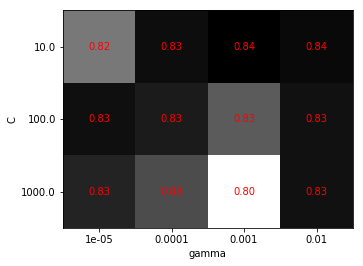

In [25]:
tempdf = gs_results_df.loc[gs_results_df.param_kernel == "rbf"]
toPlot = np.zeros((len(Cs_rbf), len(gammas_rbf)))
for i, hls in enumerate(Cs_rbf):
    for j, a in enumerate(gammas_rbf):
        k = i * len(gammas_rbf) + j
        toPlot[i, j] = tempdf.iloc[k].mean_test_score
heatmap(toPlot, gammas_rbf, Cs_rbf, xlabel="gamma", ylabel="C", savefig=est + pltNameSuffix + "_rbf_gs")

In [26]:
print(f'From this, we choose the following parameters for the final model:\n{gs.best_params_}')
score = gs.score(XTest, yTest)
print(f'This model has score of {gs.best_score_} in cross validation for grid search and {score} on the held-out test data')

From this, we choose the following parameters for the final model:
{'C': 10.0, 'gamma': 0.001, 'kernel': 'rbf'}
This model has score of 0.8364444444444444 in cross validation for grid search and 0.8223333333333334 on the held-out test data


# Confusion Matrix

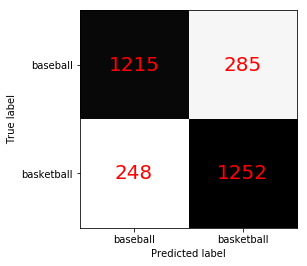

In [27]:
predictions = gs.predict(XTest)
ax = plotConfusionMatrix(yTest, predictions, names, savefig=est + pltNameSuffix + "_confusion")

# Examples of Incorrect Classifications

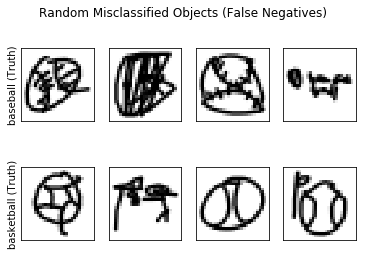

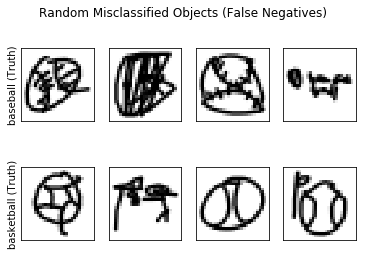

In [28]:
classNumbers = [nameDict[name] for name in names]
drawIncorrectSketches(XTest, yTest, predictions, classNumbers=[0, 1], names=names, n=4, randomSeed=randomSeed, savefig=est + pltNameSuffix + "_Misclassified")